# **Disaster Tweets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from gensim.models import Word2Vec

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Data/Disaster_tweets_NLP/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Data/Disaster_tweets_NLP/test.csv")

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# **Data Analysis**

In [ ]:
df_train.isnull().sum().sort_values(ascending = False)

,0
location,2533
keyword,61
id,0
text,0
target,0


In [ ]:
df_test.isnull().sum().sort_values(ascending = False)

,0
location,1105
keyword,26
id,0
text,0


In [ ]:
print(len(df_train))
df_train = df_train.drop_duplicates('text', keep='last')
print(len(df_test))

7613
3263


In [ ]:
df_train['target'].value_counts()

,count
target,
0,4307
1,3196


Text(0, 0.5, 'Count')

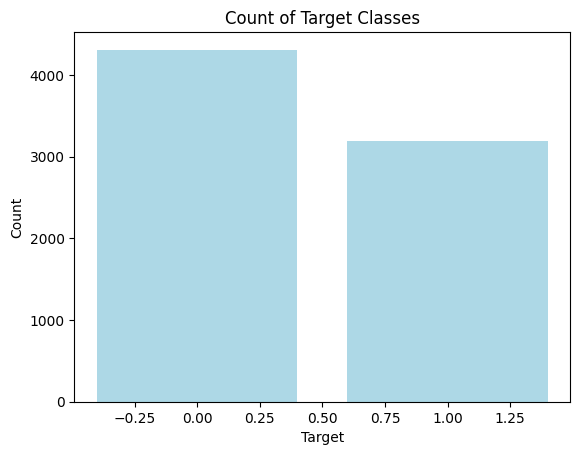

In [ ]:
counts = df_train['target'].value_counts()
plt.bar(counts.index, counts.values, color='lightblue')
plt.title('Count of Target Classes')
plt.xlabel('Target')
plt.ylabel('Count')

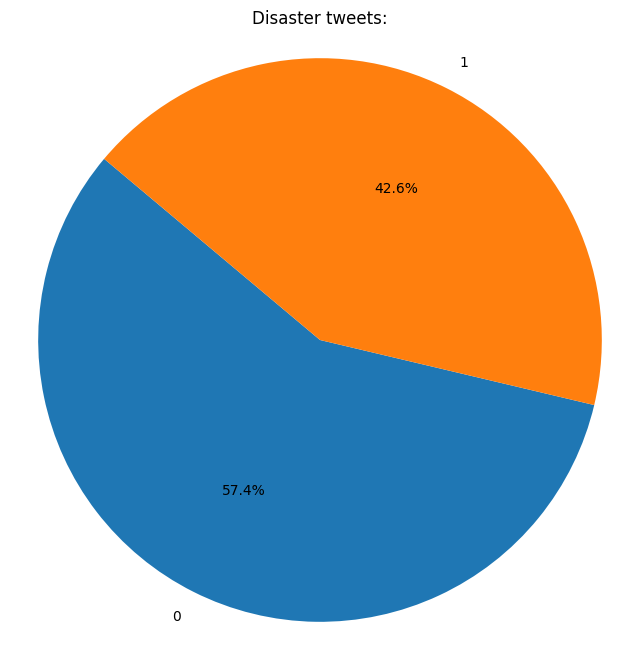

In [ ]:
category_counts = df_train['target'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Disaster tweets:')
plt.axis('equal')
plt.show()

<Axes: xlabel='count', ylabel='keyword'>

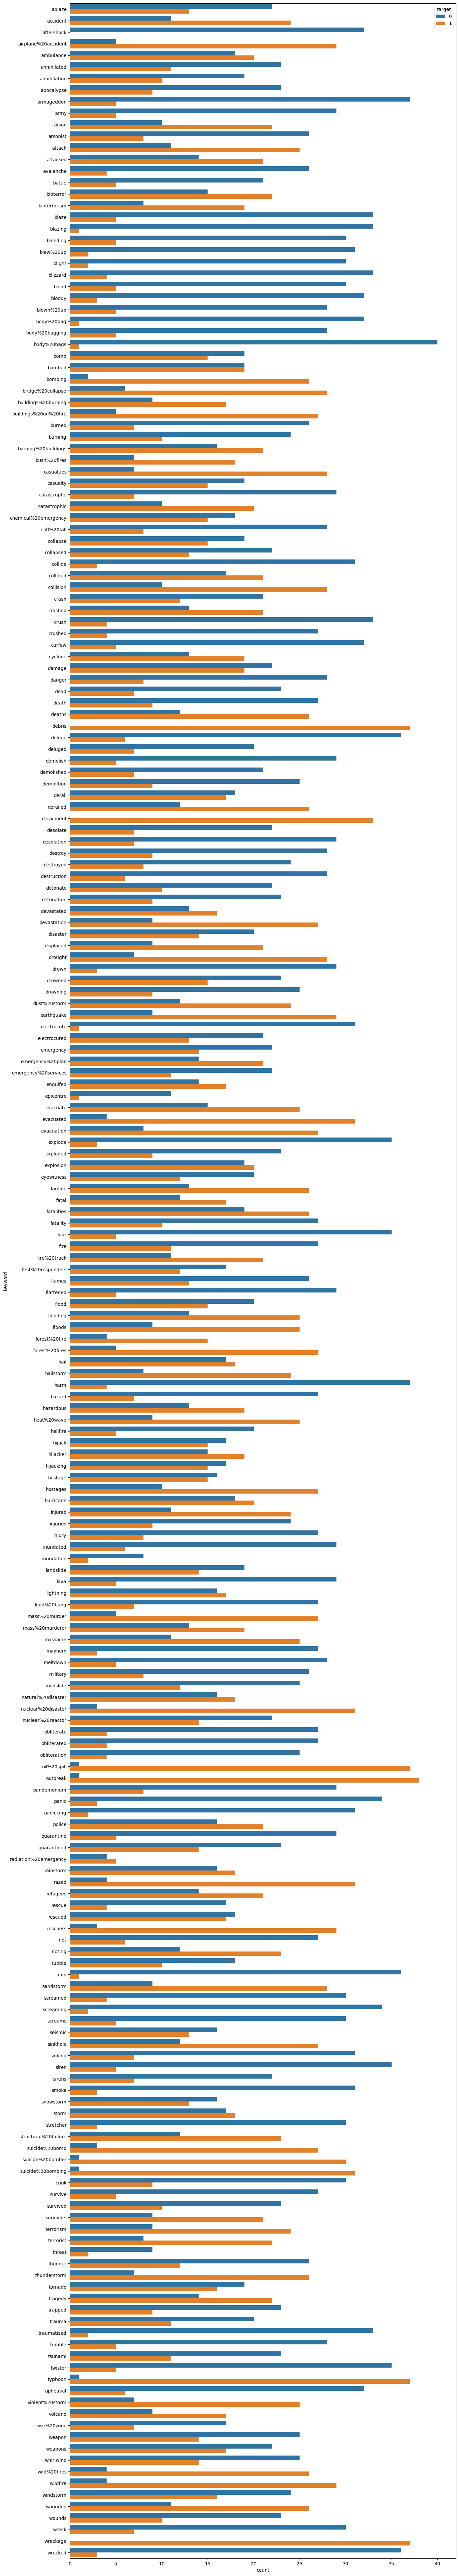

In [ ]:
plt.figure(figsize=(15,100))
sns.countplot(data=df_train, y='keyword', hue='target')

In [ ]:
# Create a binary feature in the train dataset 'has_location' based on whether 'location' is not NaN
df_train['has_location'] = pd.notna(df_train['location']).astype(int)

# Create a binary feature in the test dataset 'has_location' based on whether 'location' is not NaN
df_test['has_location'] = pd.notna(df_test['location']).astype(int)

In [ ]:
# drop the column 'location' in the train dataset
df_train.drop(['location'], axis=1, inplace=True)

# drop the column 'location' in the test dataset
df_test.drop(['location'], axis=1, inplace=True)

In [ ]:
# Replace NaN values in the 'keyword' column with a placeholder value, e.g., 'unknown'
df_train['keyword'].fillna('unknown', inplace=True)

 # Initialize the LabelEncoder
label_encoder = LabelEncoder()
df_train['keyword_encoded'] = label_encoder.fit_transform(df_train['keyword']) # Fit and transform the 'keyword' column

# Drop the original 'keyword' column
df_train.drop('keyword', axis=1, inplace=True)


<ipython-input-15-8a19ed53ab2e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['keyword'].fillna('unknown', inplace=True)


# **Blank Values filled**

In [ ]:
# Replace NaN values in the 'keyword' column with a placeholder value, e.g., 'unknown'
df_test['keyword'].fillna('unknown', inplace=True)

 # Initialize the LabelEncoder
label_encoder = LabelEncoder()
df_test['keyword_encoded'] = label_encoder.fit_transform(df_test['keyword']) # Fit and transform the 'keyword' column

# Drop the original 'keyword' column
df_test.drop('keyword', axis=1, inplace=True)

In [ ]:
df_train.head()

In [ ]:
df_test.head()

# **Stopwords/ Lemmatize/Tokenize**

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
# Preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Remove URLs, special characters, numbers, and convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+|\d+|#[\w]+', '', text).lower()
    text = re.sub(r'[^\w\s]', '', text)

    # Lemmatize words and remove stopwords
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return words

In [ ]:
# Apply preprocessing
df_train['tokenized_text'] = df_train['text'].apply(preprocess_text)
df_test['tokenized_text'] = df_test['text'].apply(preprocess_text)

# **Word to Vector**

In [ ]:
# Train Word2Vec model
all_sentences = df_train['tokenized_text'].tolist() + df_test['tokenized_text'].tolist()
word2vec_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

In [ ]:
# Function to compute sentence embeddings
def get_sentence_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
# Compute sentence embeddings
df_train['sentence_vector'] = df_train['tokenized_text'].apply(lambda x: get_sentence_vector(x, word2vec_model))
df_test['sentence_vector'] = df_test['tokenized_text'].apply(lambda x: get_sentence_vector(x, word2vec_model))

In [ ]:
sns.heatmap(df_train.corr(numeric_only=True),annot=True,cmap='coolwarm')

# **Data to train model**

# Stack the features together
X_train = np.vstack(df_train['sentence_vector'].values)
X_train_combined = np.hstack([X_train, df_train[['keyword_encoded', 'has_location']].values])

test_x = np.vstack(df_test['sentence_vector'].values)
X_test_combined = np.hstack([test_x, df_test[['keyword_encoded', 'has_location']].values])

# Target variable
y_train = df_train['target']


In [ ]:
X_train_combined.shape

In [ ]:
X_test_combined.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
y_train = y_train.ravel()